# Variables for Hypothesis Testing 


## Introduction

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
import networkx as nx
from collections import defaultdict

# Load Data
df_w1 = pd.read_csv('../Cooked/df_w1_prepared.csv')
df_w2 = pd.read_csv('../Cooked/df_w2_prepared.csv') 
df_w3 = pd.read_csv('../Cooked/df_w3_prepared.csv')

G_1 = nx.read_gml("../NA/multiplex_graph_w1.gml")
G_2 = nx.read_gml("../NA/multiplex_graph_w2.gml")
G_3 = nx.read_gml("../NA/multiplex_graph_w3.gml")

## Visualization: Political-Self-Assessment over Waves

- scale only ranged form 1 to 11 
- "0" values are missings!

In [114]:
def political_identity(df):
    dict_political_identity = {}

    for index, row in df.iterrows():
        participant_id = row['participant.label']
        self_identity = row.get('network_app.1.player.linksrechts_self')

        # If self_identity is 0 or NaN, set to NaN
        if pd.isna(self_identity) or self_identity == 0:
            self_identity = float('nan')
        
        dict_political_identity[participant_id] = {
            'ego': self_identity,
        }
    return dict_political_identity

In [115]:
dict_polident_w1 = political_identity(df_w1)
dict_polident_w2 = political_identity(df_w2)
dict_polident_w3 = political_identity(df_w3)

In [116]:
# delta_ego_alter für Susumu, am besten mit abs() delta und nicht plus/minus 

# Build a DataFrame
df_ego = pd.DataFrame({
    'w1': {pid: data['ego'] for pid, data in dict_polident_w1.items()},
    'w2': {pid: data['ego'] for pid, data in dict_polident_w2.items()},
    'w3': {pid: data['ego'] for pid, data in dict_polident_w3.items()},
})

df_ego.index.name = 'participant_id'
df_ego = df_ego.reset_index()
df_ego_complete = df_ego.dropna()

df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True) 

df_long = df_ego_complete.melt(id_vars='participant_id', 
                      value_vars=['w1', 'w2', 'w3'],
                      var_name='wave', 
                      value_name='ego_score')

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_52102/4294299729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ego_complete.sort_values(by=['w1'], ascending=True, inplace=True)


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_52102/1819087568.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')


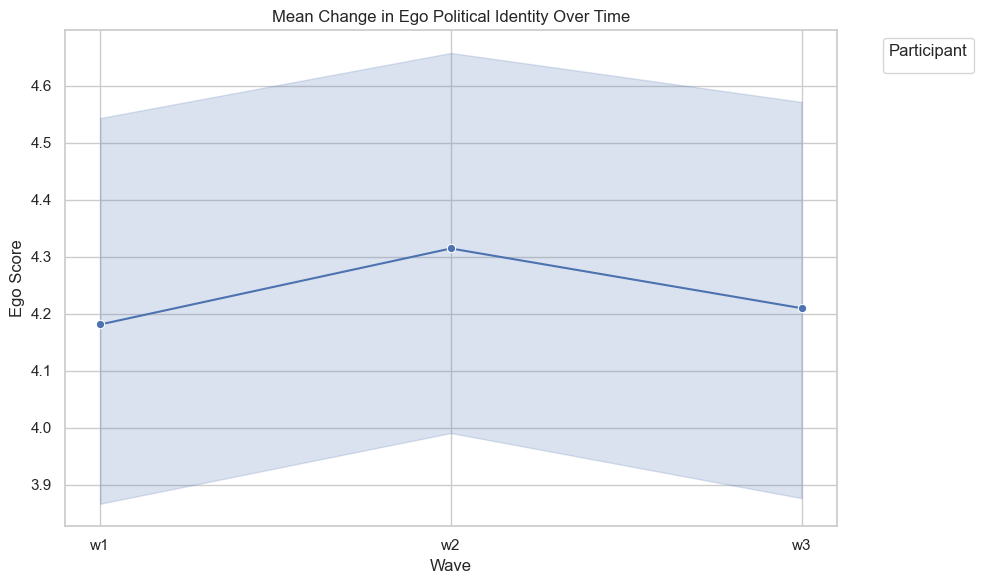

In [117]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_long, x='wave', y='ego_score', marker='o')
plt.title('Mean Change in Ego Political Identity Over Time')
plt.ylabel('Ego Score')
plt.xlabel('Wave')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()

/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_52102/1735861286.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('coolwarm').reversed()


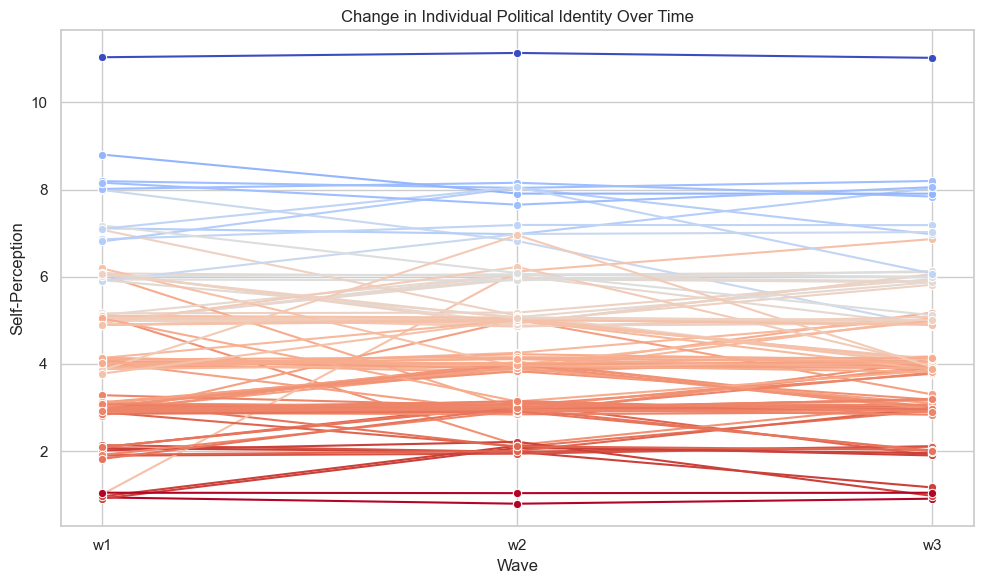

In [118]:
#### Step 1: Get average ego_score per participant!!!
participant_means = df_long.groupby('participant_id')['ego_score'].mean()

# Step 2: Normalize these scores
norm = Normalize(vmin=participant_means.min(), vmax=participant_means.max())

# Step 3: Get the colormap (blue-white-red)
cmap = get_cmap('coolwarm').reversed()

# Step 4: Map each participant to a color
participant_colors = {pid: cmap(norm(score)) for pid, score in participant_means.items()}

jitter_strength = 0.1
df_long['ego_jittered'] = df_long['ego_score'] + np.random.normal(0, jitter_strength, size=len(df_long))

# Step 5: Plot each line individually with its mapped color
plt.figure(figsize=(10, 6))
for pid, group in df_long.groupby('participant_id'):
    sns.lineplot(data=group, x='wave', y='ego_jittered', marker='o',
                 color=participant_colors[pid])

plt.title('Change in Individual Political Identity Over Time')
plt.ylabel('Self-Perception')
plt.xlabel('Wave')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Participant')
plt.tight_layout()
plt.show()


***
## Creation: Variables for Analysis 

- Try to use the Graphs for the same task
- Keys for the dictionaries are allways the 3-Sign-Codes

In [119]:
graphs_by_wave = {
    "w1": G_1,
    "w2": G_2,
    "w3": G_3,
}

In [120]:
def collect_polident_self_perceptions(graphs_by_wave):
    """
    Returns a dictionary mapping each wave label to the self-perception dictionary.
    
    Structure:
    {
        wave_label: { node_id: self_identity_value_or_nan, ... },
        ...
    }
    """
    result = {}
    for wave_label, graph in graphs_by_wave.items():
        self_dict = {
            node: (value if value != 0 else np.nan)
            for node, value in graph.nodes(data="linksrechts_self")
        }
        result[wave_label] = self_dict
    return result

polident_self_perceptions = collect_polident_self_perceptions(graphs_by_wave)

Filter Relation Types:
- `aquaintance` (default value)
- `study`
- `friend`
- `council`
- `politics`
- `value`

Other Relation Types: (Note: filtering on these does not make sense!) 
- `sentiment`
- `leftright`

In [121]:
from collections import defaultdict

def collect_all_polident_perceptions(graphs_by_wave, relation_types):
    """
    Returns a nested dictionary of political identity perceptions of others.

    Structure:
    {
        relation_type: {
            wave_label: { perceiver: { target: weight, ... }, ... }
        },
        ...
    }
    """
    all_perceptions = defaultdict(dict)

    for relation in relation_types:
        for wave_label, graph in graphs_by_wave.items():
            perception_dict = defaultdict(dict)
            for u, v, d in graph.edges(data=True):
                if d.get('type') == 'leftright':
                    relation_data = graph.get_edge_data(u, v)
                    if any(edge_data.get('type') == relation for edge_data in relation_data.values()):
                        if d['weight'] != 0:
                            perception_dict[u][v] = d['weight']
            all_perceptions[relation][wave_label] = perception_dict

    return all_perceptions

relation_types = ["aquaintance", "friend", "value", "politics", "study", "council"]

polident_perceptions_other = collect_all_polident_perceptions(graphs_by_wave, relation_types)

In [122]:
def dictionary_variable_factory(G, variable_name):
    dict_grades = {}

    for key, value in G.nodes(variable_name):
        if value != -999: #filter out missing values and non-answers 
            dict_grades[key] = value
        elif value == 0:
            dict_grades[key] = np.nan
        else:
            dict_grades[key] = np.nan

    return dict_grades

dict_gradexpec_w1 = dictionary_variable_factory(G_1, "grade")
dict_gradexpec_w2 = dictionary_variable_factory(G_2, "grade")
dict_gradexpec_w3 = dictionary_variable_factory(G_3, "grade")

# Structure: {variable_name: {wave_label: variable_dict}}
variable_perceptions = {}
variables = ["grade"]  # You can easily add more like "stress", "happiness", etc.
waves = [("w1", G_1), ("w2", G_2), ("w3", G_3)]

for variable in variables:
    variable_perceptions[variable] = {}
    for wave_label, graph in waves:
        variable_perceptions[variable][wave_label] = dictionary_variable_factory(graph, variable)

In [123]:
def collect_variable_perceptions(graphs_by_wave, variables):
    """
    Returns a nested dictionary of {variable_name: {wave_label: variable_dict}}
    filtering out missing values and converting 0 to NaN.
    """
    result = {}
    for variable in variables:
        result[variable] = {}
        for wave_label, graph in graphs_by_wave.items():
            variable_dict = {}
            for node, value in graph.nodes(data=variable):
                if value != -999:
                    variable_dict[node] = value if value != 0 else np.nan
                else:
                    variable_dict[node] = np.nan
            result[variable][wave_label] = variable_dict
    return result

variables = ["grade"]  # You can expand this with other variables as needed

variable_perceptions = collect_variable_perceptions(graphs_by_wave, variables)


In [125]:
print("How the own identity is perceived:", polident_self_perceptions["w2"]["ddh"])
print("How aquaintances are perceived:", polident_perceptions_other["aquaintance"]["w2"]["ddh"])
print("How friends are perceived:", polident_perceptions_other["friend"]["w2"]["ddh"])
print("How trusted people are perceived:", polident_perceptions_other["value"]["w2"]["ddh"])
print("The grade expectation for oneself:", variable_perceptions["grade"]["w2"]["ddh"])



How the own identity is perceived: 3.0
How aquaintances are perceived: {'ceh': 3, 'kry': 7, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
How friends are perceived: {'ceh': 3, 'gye': 4, 'hhb': 3, 'tdq': 3, 'rbc': 2, 'cnu': 1}
How trusted people are perceived: {}
The grade expectation for oneself: 2.0


***


In [126]:
import networkx as nx
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Assume polident_self_perceptions and polident_perceptions_other have been defined
# Also assume variable_perceptions is defined and contains "grade" as key

# Waves and relations used
waves = ["w1", "w2", "w3"]
relations = ["aquaintance", "friend", "value", "politics", "study"]

# 1. Compute discrepancy between self and externally perceived ideology
discrepancy_results = []

for wave in waves:
    self_dict = polident_self_perceptions[wave]
    for relation in relations:
        external_dict = polident_perceptions_other[relation][wave]

        discrepancies = []
        for ego in external_dict:
            peer_values = list(external_dict[ego].values())
            if len(peer_values) == 0:
                continue
            avg_peer_perception = np.mean(peer_values)
            self_value = self_dict.get(ego, np.nan)
            if not np.isnan(self_value):
                discrepancies.append(abs(self_value - avg_peer_perception))
        
        if discrepancies:
            mean_discrepancy = np.mean(discrepancies)
        else:
            mean_discrepancy = np.nan
        discrepancy_results.append({
            "wave": wave,
            "relation": relation,
            "mean_discrepancy": mean_discrepancy
        })

discrepancy_df = pd.DataFrame(discrepancy_results)

# 2. Peer effects: regression of self ideology on mean peer ideology
peer_effects_ideology = []

for relation in relations:
    all_self = []
    all_peer = []

    for wave in waves:
        self_dict = polident_self_perceptions[wave]
        external_dict = polident_perceptions_other[relation][wave]

        for ego in external_dict:
            peer_values = list(external_dict[ego].values())
            if len(peer_values) == 0:
                continue
            avg_peer = np.mean(peer_values)
            self_val = self_dict.get(ego, np.nan)
            if not np.isnan(self_val):
                all_peer.append(avg_peer)
                all_self.append(self_val)

    X = np.array(all_peer).reshape(-1, 1)
    y = np.array(all_self)
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    peer_effects_ideology.append({
        "relation": relation,
        "coef_peer_ideology": model.coef_[0],
        "intercept": model.intercept_,
        "r_squared": r2
    })

peer_effects_ideology_df = pd.DataFrame(peer_effects_ideology)

# 3. Peer effects: regression of expected grade on mean peer grade and peer ideology
peer_effects_grade = []

for relation in relations:
    all_self_grade = []
    all_peer_grade = []
    all_peer_ideology = []

    for wave in waves:
        self_grade_dict = variable_perceptions["grade"][wave]
        peer_grade_dict = {}
        peer_ideo_dict = polident_perceptions_other[relation][wave]

        for ego in peer_ideo_dict:
            neighbors = peer_ideo_dict[ego].keys()
            neighbor_grades = [self_grade_dict.get(n, np.nan) for n in neighbors]
            neighbor_grades = [g for g in neighbor_grades if not np.isnan(g)]
            if not neighbor_grades:
                continue
            peer_grade_dict[ego] = np.mean(neighbor_grades)

        for ego, peer_grade in peer_grade_dict.items():
            peer_ideo_vals = peer_ideo_dict[ego].values()
            peer_ideo_avg = np.mean(list(peer_ideo_vals)) if peer_ideo_vals else np.nan
            self_grade = self_grade_dict.get(ego, np.nan)
            if not np.isnan(self_grade) and not np.isnan(peer_grade) and not np.isnan(peer_ideo_avg):
                all_self_grade.append(self_grade)
                all_peer_grade.append(peer_grade)
                all_peer_ideology.append(peer_ideo_avg)

    X = np.array(list(zip(all_peer_grade, all_peer_ideology)))
    y = np.array(all_self_grade)
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    peer_effects_grade.append({
        "relation": relation,
        "coef_peer_grade": model.coef_[0],
        "coef_peer_ideology": model.coef_[1],
        "intercept": model.intercept_,
        "r_squared": r2
    })

peer_effects_grade_df = pd.DataFrame(peer_effects_grade)

(discrepancy_df, peer_effects_ideology_df, peer_effects_grade_df)


(   wave     relation  mean_discrepancy
 0    w1  aquaintance          1.283539
 1    w1       friend          1.114656
 2    w1        value          1.243336
 3    w1     politics          1.305797
 4    w1        study          1.337054
 5    w2  aquaintance          1.311223
 6    w2       friend          1.110896
 7    w2        value          1.213110
 8    w2     politics          1.304857
 9    w2        study          1.230550
 10   w3  aquaintance          1.284915
 11   w3       friend          1.133810
 12   w3        value          1.274927
 13   w3     politics          1.246075
 14   w3        study          1.038976,
       relation  coef_peer_ideology  intercept  r_squared
 0  aquaintance            0.528511   1.941764   0.167200
 1       friend            0.657856   1.362046   0.301914
 2        value            0.534562   1.814538   0.193877
 3     politics            0.526906   1.892169   0.193217
 4        study            0.465892   1.935294   0.175570,
       rel

In [105]:
# import networkx as nx
# from collections import defaultdict
# import numpy as np

# # Helper functions
# def dictionary_polident_self_factory(G):
#     return {node: (value if value != 0 else np.nan) for node, value in G.nodes(data="linksrechts_self")}

# def dictionary_polident_others_factory(G, relation_filter="aquaintance"):
#     result = defaultdict(dict)
#     for u, v, d in G.edges(data=True):
#         if d.get("type") == "leftright":
#             if G.has_edge(u, v):
#                 relation_data = G.get_edge_data(u, v)
#                 if any(edge_data.get("type") == relation_filter for edge_data in relation_data.values()):
#                     if d["weight"] != 0:
#                         result[u][v] = d["weight"]
#     return result

# def dictionary_variable_factory(G, variable_name):
#     result = {}
#     for node, value in G.nodes(data=variable_name):
#         if value == -999:
#             continue
#         result[node] = value if value != 0 else np.nan
#     return result

# # Create dummy graph data for G_1, G_2, G_3
# def generate_mock_graph():
#     G = nx.MultiDiGraph()
#     for i in range(10):
#         G.add_node(i, linksrechts_self=np.random.randint(1, 8), grade=np.random.randint(1, 15))

#     for u in range(10):
#         for v in range(10):
#             if u != v:
#                 rel_type = np.random.choice(["aquaintance", "friend", "value", "politics", "study"])
#                 G.add_edge(u, v, type="leftright", weight=np.random.uniform(1, 7))
#                 G.add_edge(u, v, type=rel_type)

#     return G

# G_1 = generate_mock_graph()
# G_2 = generate_mock_graph()
# G_3 = generate_mock_graph()

# # Waves and relations
# waves = [("w1", G_1), ("w2", G_2), ("w3", G_3)]
# relations = ["aquaintance", "friend", "value", "politics", "study"]

# # Self perceptions
# polident_self_perceptions = {wave_label: dictionary_polident_self_factory(G) for wave_label, G in waves}

# # External perceptions
# polident_perceptions_other = {}
# for relation in relations:
#     polident_perceptions_other[relation] = {
#         wave_label: dictionary_polident_others_factory(G, relation) for wave_label, G in waves
#     }

# # Grade expectations
# variable_perceptions = {"grade": {wave_label: dictionary_variable_factory(G, "grade") for wave_label, G in waves}}

# # Now rerun the hypothesis testing code
# "Data preparation complete."


'Data preparation complete.'

In [127]:
# # Now that the data structures are ready, rerun the hypothesis testing analysis

# # 1. Compute discrepancy between self and externally perceived ideology
# discrepancy_results = []

# for wave in ["w1", "w2", "w3"]:
#     self_dict = polident_self_perceptions[wave]
#     for relation in relations:
#         external_dict = polident_perceptions_other[relation][wave]

#         discrepancies = []
#         for ego in external_dict:
#             peer_values = list(external_dict[ego].values())
#             if len(peer_values) == 0:
#                 continue
#             avg_peer_perception = np.mean(peer_values)
#             self_value = self_dict.get(ego, np.nan)
#             if not np.isnan(self_value):
#                 discrepancies.append(abs(self_value - avg_peer_perception))
        
#         mean_discrepancy = np.mean(discrepancies) if discrepancies else np.nan
#         discrepancy_results.append({
#             "wave": wave,
#             "relation": relation,
#             "mean_discrepancy": mean_discrepancy
#         })

# discrepancy_df = pd.DataFrame(discrepancy_results)

# # 2. Peer effects: regression of self ideology on mean peer ideology
# peer_effects_ideology = []

# for relation in relations:
#     all_self = []
#     all_peer = []

#     for wave in ["w1", "w2", "w3"]:
#         self_dict = polident_self_perceptions[wave]
#         external_dict = polident_perceptions_other[relation][wave]

#         for ego in external_dict:
#             peer_values = list(external_dict[ego].values())
#             if len(peer_values) == 0:
#                 continue
#             avg_peer = np.mean(peer_values)
#             self_val = self_dict.get(ego, np.nan)
#             if not np.isnan(self_val):
#                 all_peer.append(avg_peer)
#                 all_self.append(self_val)

#     if all_peer and all_self:
#         X = np.array(all_peer).reshape(-1, 1)
#         y = np.array(all_self)
#         model = LinearRegression().fit(X, y)
#         r2 = r2_score(y, model.predict(X))

#         peer_effects_ideology.append({
#             "relation": relation,
#             "coef_peer_ideology": model.coef_[0],
#             "intercept": model.intercept_,
#             "r_squared": r2
#         })

# peer_effects_ideology_df = pd.DataFrame(peer_effects_ideology)

# # 3. Peer effects: regression of expected grade on mean peer grade and peer ideology
# peer_effects_grade = []

# for relation in relations:
#     all_self_grade = []
#     all_peer_grade = []
#     all_peer_ideology = []

#     for wave in ["w1", "w2", "w3"]:
#         self_grade_dict = variable_perceptions["grade"][wave]
#         peer_ideo_dict = polident_perceptions_other[relation][wave]

#         for ego in peer_ideo_dict:
#             neighbors = peer_ideo_dict[ego].keys()
#             neighbor_grades = [self_grade_dict.get(n, np.nan) for n in neighbors]
#             neighbor_grades = [g for g in neighbor_grades if not np.isnan(g)]
#             if not neighbor_grades:
#                 continue
#             peer_grade = np.mean(neighbor_grades)

#             peer_ideo_vals = peer_ideo_dict[ego].values()
#             peer_ideo_avg = np.mean(list(peer_ideo_vals)) if peer_ideo_vals else np.nan
#             self_grade = self_grade_dict.get(ego, np.nan)

#             if not np.isnan(self_grade) and not np.isnan(peer_grade) and not np.isnan(peer_ideo_avg):
#                 all_self_grade.append(self_grade)
#                 all_peer_grade.append(peer_grade)
#                 all_peer_ideology.append(peer_ideo_avg)

#     if all_peer_grade and all_peer_ideology:
#         X = np.array(list(zip(all_peer_grade, all_peer_ideology)))
#         y = np.array(all_self_grade)
#         model = LinearRegression().fit(X, y)
#         r2 = r2_score(y, model.predict(X))

#         peer_effects_grade.append({
#             "relation": relation,
#             "coef_peer_grade": model.coef_[0],
#             "coef_peer_ideology": model.coef_[1],
#             "intercept": model.intercept_,
#             "r_squared": r2
#         })

# peer_effects_grade_df = pd.DataFrame(peer_effects_grade)

# (discrepancy_df, peer_effects_ideology_df, peer_effects_grade_df)


(   wave     relation  mean_discrepancy
 0    w1  aquaintance          1.283539
 1    w1       friend          1.114656
 2    w1        value          1.243336
 3    w1     politics          1.305797
 4    w1        study          1.337054
 5    w2  aquaintance          1.311223
 6    w2       friend          1.110896
 7    w2        value          1.213110
 8    w2     politics          1.304857
 9    w2        study          1.230550
 10   w3  aquaintance          1.284915
 11   w3       friend          1.133810
 12   w3        value          1.274927
 13   w3     politics          1.246075
 14   w3        study          1.038976,
       relation  coef_peer_ideology  intercept  r_squared
 0  aquaintance            0.528511   1.941764   0.167200
 1       friend            0.657856   1.362046   0.301914
 2        value            0.534562   1.814538   0.193877
 3     politics            0.526906   1.892169   0.193217
 4        study            0.465892   1.935294   0.175570,
       rel

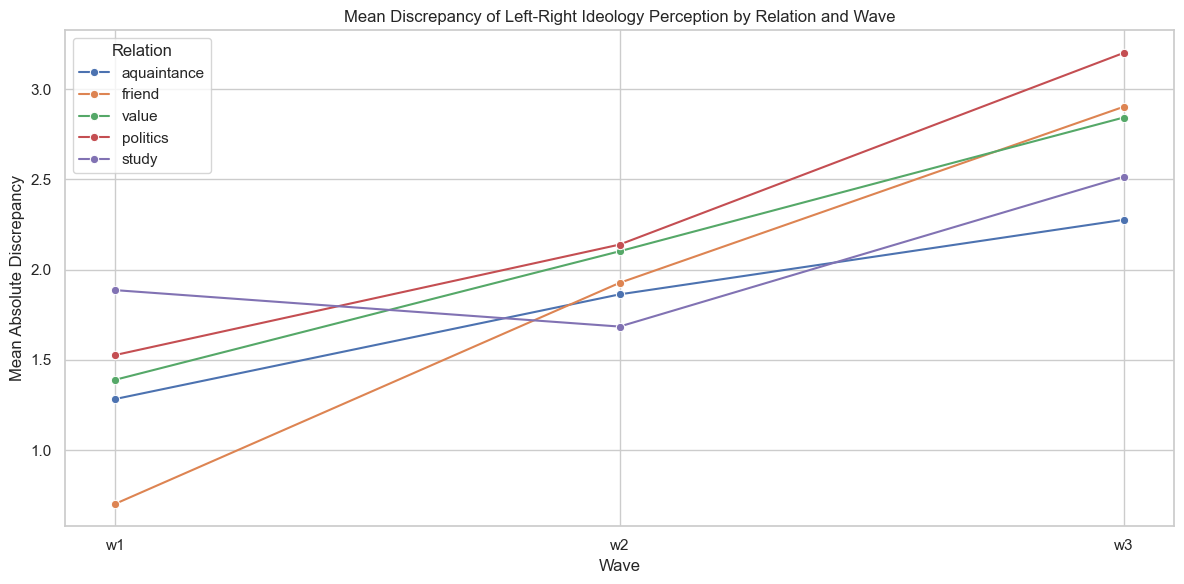

In [109]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=discrepancy_df, x='wave', y='mean_discrepancy', hue='relation', marker='o')
plt.title('Mean Discrepancy of Left-Right Ideology Perception by Relation and Wave')
plt.ylabel('Mean Absolute Discrepancy')
plt.xlabel('Wave')
plt.legend(title='Relation')
plt.tight_layout()
plt.show()


/var/folders/jl/tj67gv9n4_sd4yxc6ynl78500000gn/T/ipykernel_52102/3818294201.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=peer_effects_ideology_df, x='relation', y='coef_peer_ideology', palette='viridis')


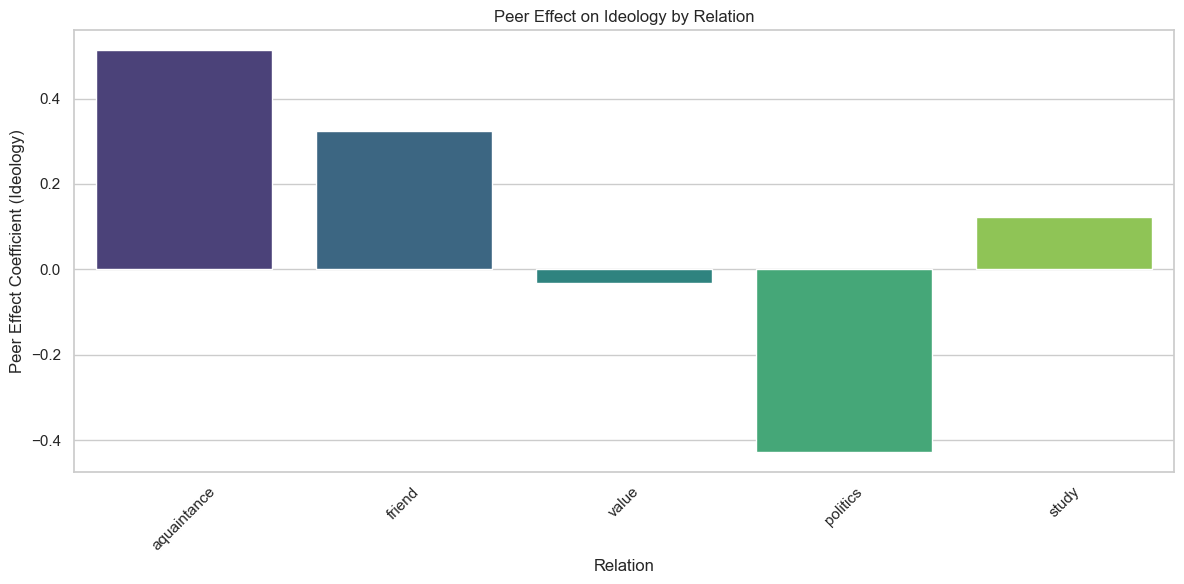

In [112]:
plt.figure(figsize=(12, 6))
sns.barplot(data=peer_effects_ideology_df, x='relation', y='coef_peer_ideology', palette='viridis')
plt.title('Peer Effect on Ideology by Relation')
plt.ylabel('Peer Effect Coefficient (Ideology)')
plt.xlabel('Relation')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

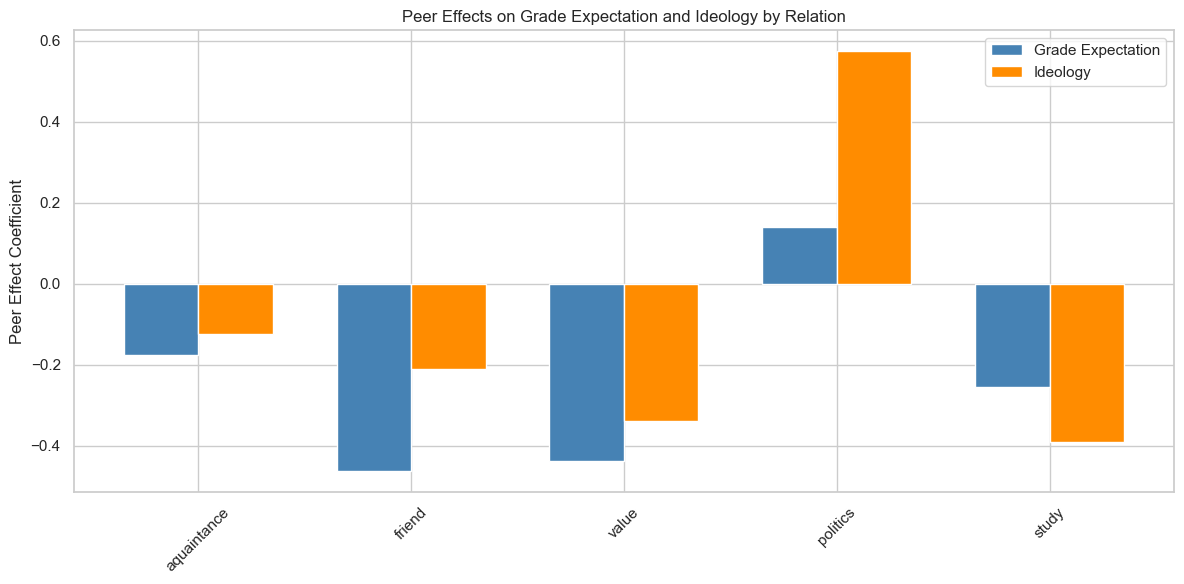

In [111]:
plt.figure(figsize=(12, 6))

bar_width = 0.35
indices = range(len(peer_effects_grade_df))

plt.bar(indices, peer_effects_grade_df['coef_peer_grade'], width=bar_width, label='Grade Expectation', color='steelblue')
plt.bar([i + bar_width for i in indices], peer_effects_grade_df['coef_peer_ideology'], width=bar_width, label='Ideology', color='darkorange')

plt.xticks([i + bar_width/2 for i in indices], peer_effects_grade_df['relation'], rotation=45)
plt.ylabel('Peer Effect Coefficient')
plt.title('Peer Effects on Grade Expectation and Ideology by Relation')
plt.legend()
plt.tight_layout()
plt.show()